In [145]:
import pip
import sys
!pip install plotly
!pip install opencv-python
!pip install scikit_posthocs

In [146]:
import numpy as np
import plotly
import imageio.v2 as imageio
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import os
import cv2 
from skimage import img_as_ubyte
from skimage import exposure
from skimage.color import rgb2gray
from skimage import data, filters, measure, morphology
from skimage.measure import label, regionprops, regionprops_table
from skimage.filters import difference_of_gaussians, gaussian, threshold_local, threshold_yen
from skimage.morphology import square, disk
import scipy.stats as ss # for statistical testing
import scikit_posthocs as sp # for posthoc testing



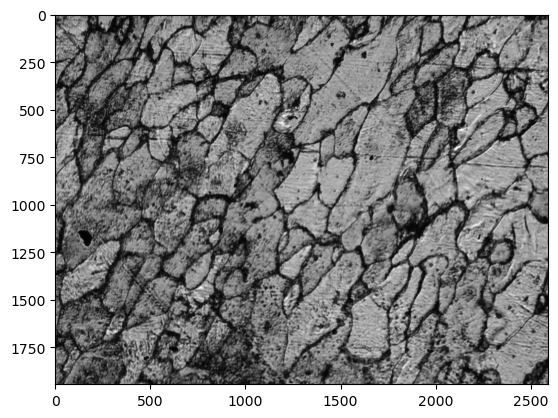

In [25]:
imagename = 'X28_1' #change here the file name
image1 = cv2.imread(imagename+'.jpg')
img_grey= cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY )
plt.imshow(img_grey, cmap='gray')

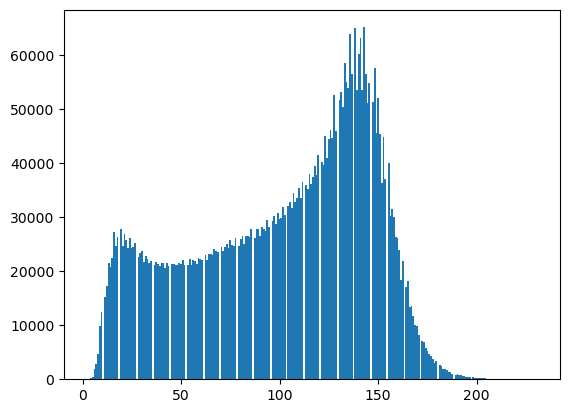

In [26]:
plt.hist(img_grey.ravel(), bins=256)
plt.show()

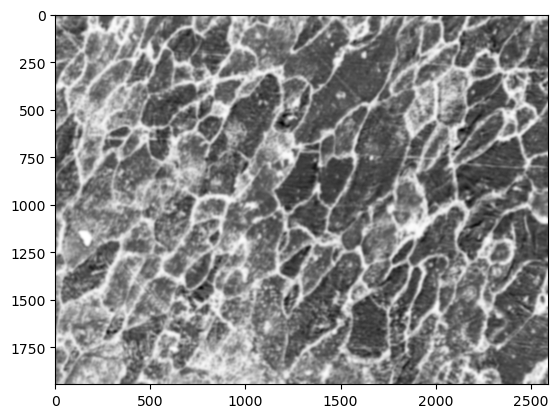

In [27]:
img_inv = 255-img_grey
img_gaus= gaussian(img_inv, sigma=5)
plt.imshow(img_gaus, cmap='gray')

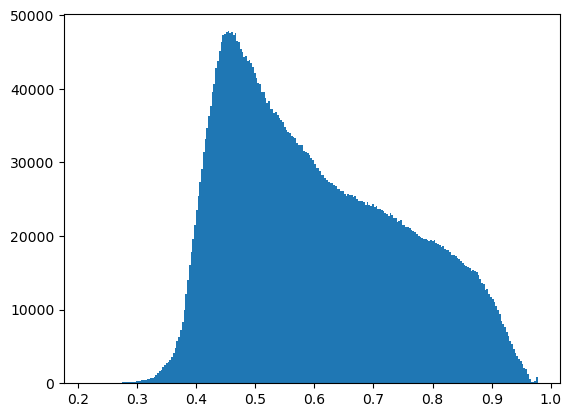

In [28]:
plt.hist(img_gaus.ravel(), bins=256)
plt.show()

[[0.65811933 0.65808166 0.65800634 ... 0.72771453 0.72766566 0.7276412 ]
 [0.65810078 0.65806311 0.65798779 ... 0.72762834 0.72757947 0.727555  ]
 [0.65806367 0.65802601 0.6579507  ... 0.72745606 0.72740719 0.72738272]
 ...
 [0.683989   0.68399288 0.68400062 ... 0.74735253 0.74727925 0.74724256]
 [0.684008   0.68401187 0.6840196  ... 0.74728464 0.74721123 0.74717448]
 [0.6840175  0.68402137 0.6840291  ... 0.74725066 0.74717718 0.7471404 ]]


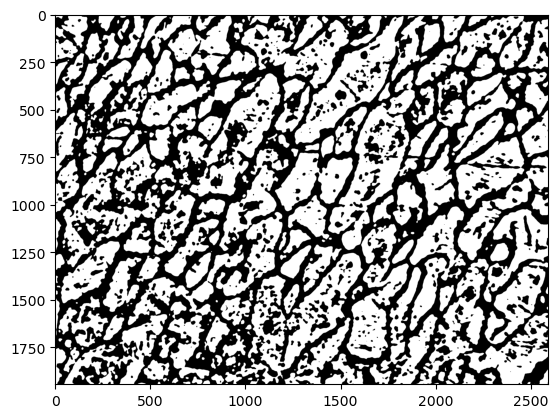

In [79]:
block_size = 251
threshold = threshold_local(img_gaus, block_size)

#threshold = filters.threshold_yen(img_gaus)
print(threshold)
mask = img_gaus < threshold *1
plt.imshow(mask, cmap='gray')

,area,perimeter,eccentricity,solidity
0,13212.0,631.114790,0.703249,0.793943
1,39132.0,1869.013419,0.903305,0.618336
2,51354.0,1571.658080,0.721897,0.740067
3,11925.0,566.925974,0.932253,0.887343
4,137836.0,2914.279580,0.956315,0.791756
...,...,...,...,...
82,6069.0,489.563492,0.965854,0.753352
83,1.0,0.000000,0.000000,1.000000
84,15229.0,968.032575,0.561888,0.671710
85,10012.0,498.315801,0.649852,0.851361


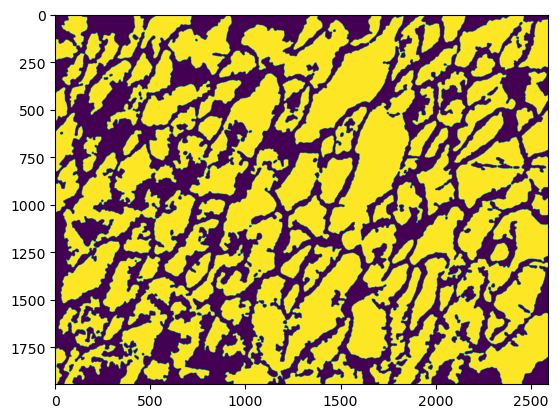

In [80]:

mask1 = morphology.remove_small_objects(mask, min_size=5000)
mask1 = morphology.remove_small_holes(mask, area_threshold=10000)
mask1 = morphology.closing(mask,disk(5))

labels = measure.label(mask1)
plt.imshow(mask1)
props1 = regionprops_table(labels, properties=('area','perimeter','eccentricity','solidity'))
pd.DataFrame(props1)


In [81]:
fig = px.imshow(img_grey, binary_string=True)
fig.update_traces(hoverinfo='skip') # hover is only for label info

props = measure.regionprops(labels, img_grey)
properties = ['area','perimeter','eccentricity','solidity']

for index in range(1, labels.max()):
    label_i = props[index].label
    contour = measure.find_contours(labels == label_i, 0.5)[0]
    y, x = contour.T
    hoverinfo = ''
    for prop_name in properties:
        hoverinfo += f'<b>{prop_name}: {getattr(props[index], prop_name):.2f}</b><br>'
    fig.add_trace(go.Scatter(
        x=x, y=y, name=label_i,
        mode='lines', fill='toself', showlegend=False,
        hovertemplate=hoverinfo, hoveron='points+fills'))

fig.write_html(imagename+"segmentation.html")

In [84]:
imagename='X30_4'
dataframe = pd.DataFrame(props1)
dataframe.to_csv(imagename+'shapedata.csv', encoding='utf-8', index=False)

In [99]:
filename1 = 'X28_1shapedata.csv' 
filename2 = 'X28_2shapedata.csv' 
filename3 = 'X28_3shapedata.csv' 
filename4 = 'X28_4shapedata.csv' 
#etc for the other files
filename5 = 'X30_1shapedata.csv' 
filename6 = 'X30_2shapedata.csv' 
filename7 = 'X30_3shapedata.csv' 
filename8 = 'X30_4shapedata.csv' 

df1 = pd.read_csv(filename1)
df2 = pd.read_csv(filename2)
df3 = pd.read_csv(filename3)
df4 = pd.read_csv(filename4)
#etc for the other files
df5 = pd.read_csv(filename5)
df6 = pd.read_csv(filename6)
df7 = pd.read_csv(filename7)
df8 = pd.read_csv(filename8)

In [150]:
allMat1=pd.concat([df1,df2,df3,df4]) #etc. in your case it would be including also df5, df6
# allMat2 would then include df7-df12; allMat3 would include df13-df18
allMat2=pd.concat([df5,df6,df7,df8]) 


In [154]:
Areas=[allMat1["area"],allMat2["area"]]
Perimeter=[allMat1["perimeter"],allMat2["perimeter"]]
Eccentricities=[allMat1["eccentricity"],allMat2["eccentricity"]]
Solidity=[allMat1["solidity"],allMat2["solidity"]]

In [102]:
for df in Areas:
    print(df.sum(),df.mean(),df.std(),df.count()) 

5897256.0 42123.25714285715 39707.95235963789 140
12015547.0 28608.44523809524 47569.814829631134 420


In [103]:
for df in Perimeter:
    print(df.sum(),df.mean(),df.std(),df.count()) 

216132.11430393124 1543.8008164566518 1024.868763228303 140
545831.026864918 1299.5976830117095 1949.6630591677615 420


In [104]:
for df in Solidity:
    print(df.mean(),df.std(),df.count()) 

0.71528778980227 0.09716132679140639 140
0.7802672306977965 0.14715424031430321 420


In [105]:
for df in Eccentricities:
    print(df.mean(),df.std(),df.count()) 

0.867363405461716 0.13110102550317657 140
0.8178781195666704 0.17802833910335947 420


{'whiskers': [<matplotlib.lines.Line2D at 0x7f12ec4d57e0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f12ec4d79a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f131c3c5c60>,
 'medians': [<matplotlib.lines.Line2D at 0x7f12ec4d7fd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f12ec4d4ee0>,
 'means': [<matplotlib.lines.Line2D at 0x7f12ec4d5ae0>,
  <matplotlib.lines.Line2D at 0x7f12ec4d63b0>]}

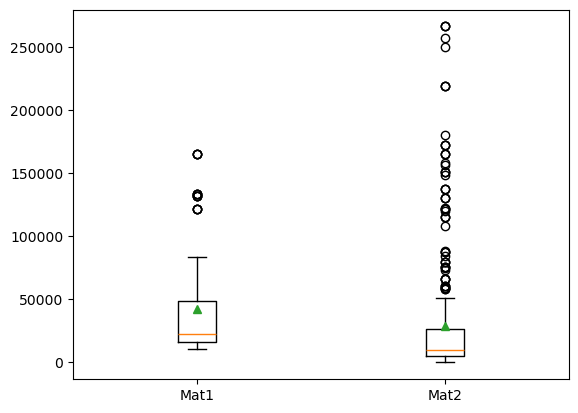

In [106]:
plt.boxplot(Areas, labels=['Mat1', 'Mat2'], showmeans=True)

In [130]:
h, w = mask1.shape
totalArea=h*w
Sum_Mat1_SegmentArea=(sum(allMat1.area))/4 #divide by number of images that were analysed
Fraction_Mat1_SegmentArea=Sum_Mat1_SegmentArea/totalArea
Sum_Mat2_SegmentArea=(sum(allMat2.area))/4 #divide by number of images that were analysed
Fraction_Mat2_SegmentArea=Sum_Mat2_SegmentArea/totalArea
print(totalArea)
print([Sum_Mat1_SegmentArea,Sum_Mat2_SegmentArea])
print([Fraction_Mat1_SegmentArea,Fraction_Mat2_SegmentArea])

5038848
[1474314.0, 3003886.75]
[0.29258949664685263, 0.5961455376308236]


In [140]:
h, w = mask1.shape
totalArea=h*w
Sum_Mat1_1_SegmentArea=(sum(df1.area))
Fraction_Mat1_1_SegmentArea=Sum_Mat1_1_SegmentArea/totalArea

Sum_Mat1_2_SegmentArea=(sum(df2.area))
Fraction_Mat1_2_SegmentArea=Sum_Mat1_2_SegmentArea/totalArea

Sum_Mat1_3_SegmentArea=(sum(df3.area))
Fraction_Mat1_3_SegmentArea=Sum_Mat1_3_SegmentArea/totalArea

Sum_Mat1_4_SegmentArea=(sum(df1.area))
Fraction_Mat1_4_SegmentArea=Sum_Mat1_4_SegmentArea/totalArea

Sum_Mat1_SegmentArea=[Sum_Mat1_1_SegmentArea,Sum_Mat1_2_SegmentArea,Sum_Mat1_3_SegmentArea,Sum_Mat1_4_SegmentArea]
Fraction_Mat1_SegmentArea=[Fraction_Mat1_1_SegmentArea,Fraction_Mat1_2_SegmentArea,Fraction_Mat1_3_SegmentArea,Fraction_Mat1_4_SegmentArea]

#same for Material 2

Sum_Mat2_1_SegmentArea=(sum(df5.area))
Fraction_Mat2_1_SegmentArea=Sum_Mat2_1_SegmentArea/totalArea

Sum_Mat2_2_SegmentArea=(sum(df6.area))
Fraction_Mat2_2_SegmentArea=Sum_Mat2_2_SegmentArea/totalArea

Sum_Mat2_3_SegmentArea=(sum(df7.area))
Fraction_Mat2_3_SegmentArea=Sum_Mat2_3_SegmentArea/totalArea

Sum_Mat2_4_SegmentArea=(sum(df8.area))
Fraction_Mat2_4_SegmentArea=Sum_Mat2_4_SegmentArea/totalArea

Sum_Mat2_SegmentArea=[Sum_Mat2_1_SegmentArea,Sum_Mat2_2_SegmentArea,Sum_Mat2_3_SegmentArea,Sum_Mat2_4_SegmentArea]
Fraction_Mat2_SegmentArea=[Fraction_Mat2_1_SegmentArea,Fraction_Mat2_2_SegmentArea,Fraction_Mat2_3_SegmentArea,Fraction_Mat2_4_SegmentArea]

Sum_Areas=[Sum_Mat1_SegmentArea,Sum_Mat2_SegmentArea]
Fractions_Areas=[Fraction_Mat1_SegmentArea,Fraction_Mat2_SegmentArea]



{'whiskers': [<matplotlib.lines.Line2D at 0x7f131c1e4dc0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f131c1e48b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f131c1e4cd0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f131c1e77f0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f131c1e4310>,
 'means': [<matplotlib.lines.Line2D at 0x7f131c1e55d0>,
  <matplotlib.lines.Line2D at 0x7f131c1e7d30>]}

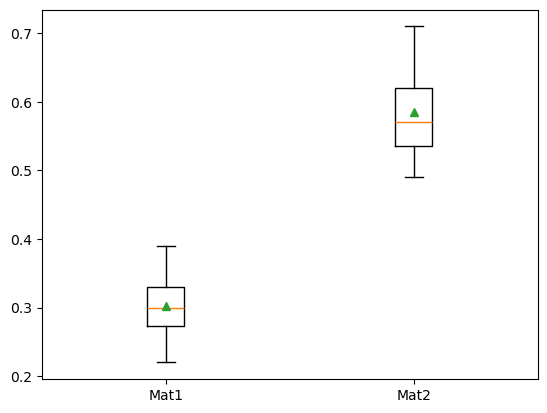

In [141]:
plt.boxplot(Fractions_Areas, labels=['Mat1', 'Mat2'], showmeans=True)

In [152]:
ss.f_oneway(allMat1["area"],allMat2["area"],allMat3["area"]) 

F_onewayResult(statistic=5.301749561424651, pvalue=0.005144586534928017)

In [155]:
sp.posthoc_mannwhitney(Areas, p_adjust = 'bonferroni')

,1,2,3
1,1.000000e+00,1.970314e-16,4.022792e-13
2,1.970314e-16,1.000000e+00,1.000000e+00
3,4.022792e-13,1.000000e+00,1.000000e+00
